In [1]:
import pandas as pd
import geopandas as gpd
import os
import sys
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn

# set the path to the root directory of the git
path_root = r'C:/Users/miln/tubCloud/Work-in-progress/main-project/new_git'

# enable python to find the modules
sys.path.append(path_root)

# import own functions
from utils.preproc_utils import import_csv_w_wkt_to_gdf

# OSM data for Berlin

In [3]:
# import OSM data with heights for Berlin
path = 'Berlin_OSM_heights.csv'
crs = 25833

berlin_w_heights = import_csv_w_wkt_to_gdf(path, crs=crs)

In [5]:
# parse building heights
berlin_w_heights['height'] = berlin_w_heights['height'].str.extract('(\d+\.?(\d+)?)')
berlin_w_heights['height'] = berlin_w_heights['height'].astype(float)

In [6]:
# total number of buildings
len(berlin_w_heights)

9476

In [7]:
berlin_w_heights = berlin_w_heights[berlin_w_heights['height']>2]

In [8]:
# buildings above 2m
len(berlin_w_heights)

8784

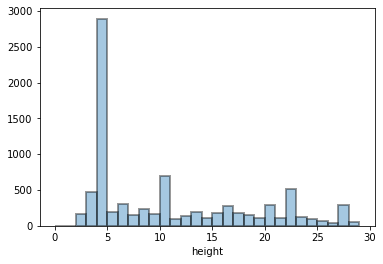

In [7]:
# height distribution
sns.distplot(berlin_w_heights.height,hist=True,kde=False,bins=range(0,30,1),norm_hist=False,
            hist_kws=dict(edgecolor="k", linewidth=2))

# Join OSM and 3D

In [11]:
# remove join column
berlin_w_heights = berlin_w_heights.drop(columns=['index_right'])

In [12]:
# import 3d data
path = 'ber_aux.csv'
crs = 25833

berlin_all = import_csv_w_wkt_to_gdf(path, crs=crs)

In [13]:
# rough spatial join based on intersections
joined_gdf = gpd.sjoin(berlin_all,berlin_w_heights,op='intersects',how='inner')

In [14]:
osm_geoms = berlin_w_heights[['Unnamed: 0','geometry']]

In [15]:
# add OSM geometries to the joined rows, to enable comparison
joined_gdf = pd.merge(joined_gdf,osm_geoms,left_on='Unnamed: 0',right_on='Unnamed: 0')

In [16]:
# compute intersection over union for all joined rows
for index,row in joined_gdf.iterrows():
    joined_gdf.loc[index,'IoU'] = row.geometry_x.intersection(row.geometry_y).area / row.geometry_x.union(row.geometry_y).area

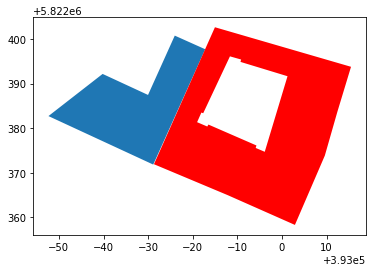

In [71]:
# plot geometries for inspection

i = 

one = joined_gdf.iloc[[i]]
two = joined_gdf.iloc[[i]]
one = one.set_geometry('geometry_x')
two = two.set_geometry('geometry_y')

fig, ax = plt.subplots()
one.plot(ax=ax)
two.plot(ax=ax, color='red')


# Comparison

In [29]:
# keep only rows with intersection over union above 80%
new_join = joined_gdf[joined_gdf.IoU > .8]

In [30]:
# number of buildings joined
len(new_join)

1997

In [31]:
# compute mean error between the two height distribution of OSM and 3D
metrics.mean_absolute_error(new_join['height_right'],new_join['height_left'])

2.6247039790405116

In [45]:
# compute OSM coverage (total OSM w/ heights divided by all buildings in 3d model)
9476/len(berlin_all)

0.018599648263300045

In [46]:
# compute number of buildings matched with the spatial join
1997/9476

0.21074292950612072

In [23]:
# prepare plot parameters
parameters = {'axes.labelsize': 15,'xtick.labelsize':15,'ytick.labelsize':15,"axes.labelweight":'normal', "axes.titlesize":20}
# parameters = {'figure.figsize': (10,10)}
plt.rcParams.update(parameters)

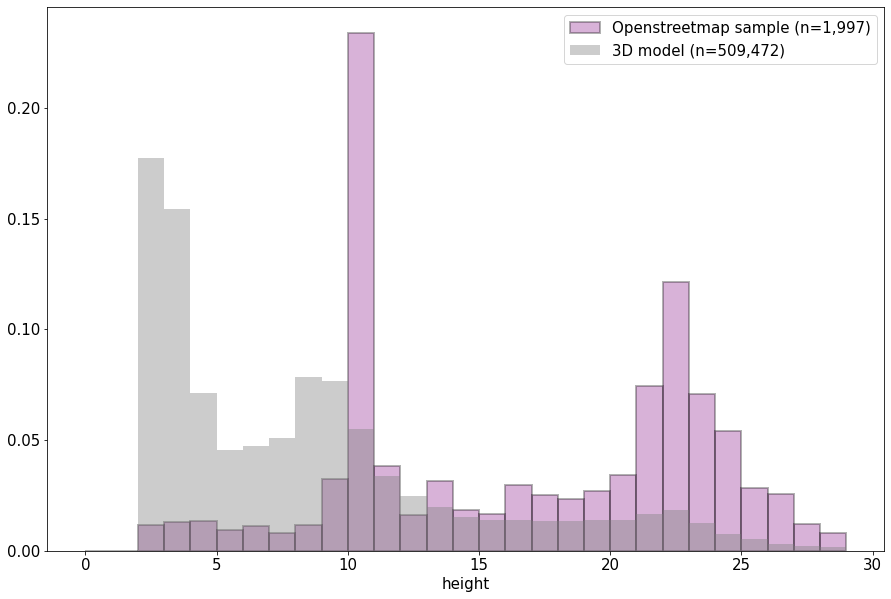

In [50]:
# plot distributions
fig, ax = plt.subplots(figsize=(15,10))

g = sns.distplot(new_join.height_left,hist=True,kde=False,bins=range(0,30,1),norm_hist=True,
            hist_kws=dict(edgecolor="k", linewidth=2, alpha=0.3), color = 'purple',
                label='Openstreetmap sample (n=1,997)')

sns.distplot(berlin_all.height,hist=True,kde=False,bins=range(0,30,1),norm_hist=True, color = 'grey',
            label='3D model (n=509,472)')

plt.legend(prop={'size': 15})
plt.title('Berlin')
plt.savefig('berlin_osm.svg')

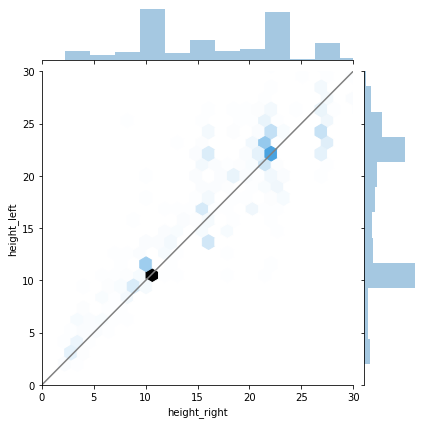

In [55]:
# plot join distribution
plot = sns.jointplot("height_right", "height_left", data=new_join, kind="hex", xlim=[0,30],ylim=[0,30],joint_kws=dict(gridsize=100))
plot.ax_joint.plot([0,30], [0,30], color = 'grey', linewidth=1.5)